In [1]:
import os
os.chdir("../")

from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pymc as pm
import arviz

from src.diffusivity import (
    within_ellipsoid, 
    calculate_lsq_diffusivities, 
    within_diffusivity_envelope, 
    linear_diffusivity
    )
from src.plots import (
    make_panel_stage_ms_plot,
    make_quantile_contour_plot,
    make_basic_diffusivity_plot,
    make_diffusivity_comparison_plot
)

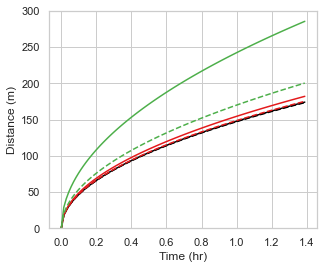

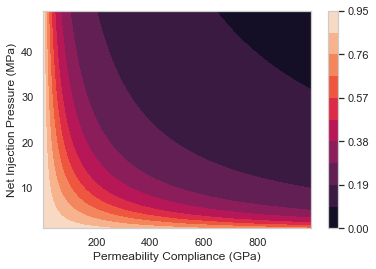

'figures\\1c_model_diagram.pdf'

In [2]:
# Figure 1 - basic model plot, quantile coutour plot, model plot
fig = make_basic_diffusivity_plot(fig_size=(4.8,4))
fig.savefig('figures/1a_basic_diffusivity_plot.pdf')
plt.show()

fig = make_quantile_contour_plot(fig_size=(6,4))
fig.savefig('figures/1b_quantile_contour_plot.pdf')
plt.show()

from src.model_graph_fixed import ModelGraph
with open('./outputs/1_14_nonlinearmodel.pkl', 'rb') as f:
    model = pickle.load(f)

gv = ModelGraph(model).make_graph()
gv.render(filename='figures/1c_model_diagram',format='pdf')

In [3]:
# microseismic data
ms_data = pd.read_parquet('proprietary/msdata.parquet')
# assign clean columns
datum_y = ms_data.QC_LOC_Y.mean()
datum_x = ms_data.QC_LOC_X.mean()
ms_data['Days'] = (ms_data.JobTime - ms_data.JobTime.min())/pd.Timedelta(1,'d')
ms_data['Magnitude'] = ms_data.SP_MAGNITUDE.astype(np.float16)
ms_data['Event Depth'] = ms_data.QC_LOC_Z.abs().astype(np.float16)
ms_data['Northing'] = ms_data.QC_LOC_Y.abs().astype(np.float32) - datum_y
ms_data['Easting'] = ms_data.QC_LOC_X.abs().astype(np.float32) - datum_x

stagedata = pd.read_csv('proprietary/stagedata.csv')
stagedata['Easting'] = stagedata['mid_x'] - datum_x
stagedata['Northing'] = stagedata['mid_y'] - datum_y
stagedata['Depth'] = -stagedata['mid_z']

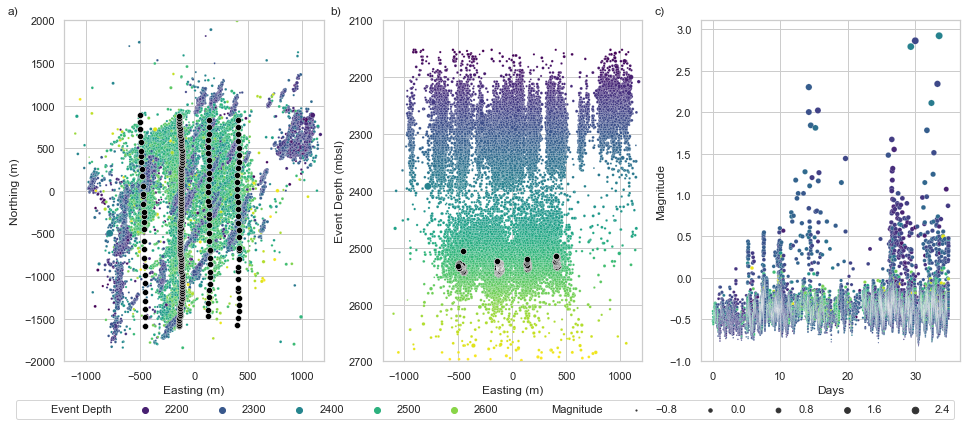

In [4]:
# Figure 2
fig = make_panel_stage_ms_plot(ms_data, stagedata, fig_size=(13.5,6))
fig.savefig('figures/2_ms_panel_plot.pdf', dpi=200)
fig.savefig('figures/2_ms_panel_plot.png', dpi=200)
plt.show()

In [5]:
# read distances
distances = pd.read_csv("data/ms_stage_distances.csv")

# run the plausible ellipsoid filter
distances["in_frac_ellipsoid"] = within_ellipsoid(
    distances[["dx_strike_m", "dy_strike_m", "dz_strike_m"]].to_numpy(),
    ellipsoid_rxryrz=(1000, 400, 600)
)

bayes_diffusivity = pd.read_csv('outputs/complete_bayes_diffusivity_results.csv')

# calculate maximum likelihood diffusivity
freq_diffusivity = (
    distances
    .query("in_frac_ellipsoid") # the filter column
    .reset_index(drop=True)
    .groupby(["WellID", "Stage"])
    .apply(calculate_lsq_diffusivities, quantile=0.95)
    .assign(model='maximum_likelihood')
    .reset_index(drop=True)
)

# merge bayesian and frequentist frames for comparison
combined_diff_results = pd.concat([bayes_diffusivity, freq_diffusivity], axis=0).groupby(["WellID","Stage","model"]).first().reset_index()

In [6]:
# run linear diffusivity and filter events within the 97% HDI of the triggering front
linear_filtered_distances = (distances
    .reset_index(drop=True)
    .assign(in_diff_ellipsoid = False)
    .groupby(["WellID", "Stage"])
    .apply(within_diffusivity_envelope, diffusivities=combined_diff_results, model='linear')
    .reset_index(drop=True)
)

# get percentage of filtered events using linear diffusivity
linear_filtered_distances.query('in_frac_ellipsoid').query('in_diff_ellipsoid').shape[0]/linear_filtered_distances.shape[0]

0.7098455431875054

In [7]:
nonlinear_filtered_distances = (distances
    .reset_index(drop=True)
    .assign(in_diff_ellipsoid = False)
    .groupby(["WellID", "Stage"])
    .apply(within_diffusivity_envelope, diffusivities=combined_diff_results, model='nonlinear')
    .reset_index(drop=True)
)

nonlinear_filtered_distances.query('in_frac_ellipsoid').query('in_diff_ellipsoid').shape[0]/nonlinear_filtered_distances.shape[0]

0.47805056128502327

In [8]:
linear_bayes_ms_data = pd.merge(ms_data, linear_filtered_distances, on='MS_EVENT_ID', how='inner')
linear_hf_data = linear_bayes_ms_data.query("in_frac_ellipsoid").query("in_diff_ellipsoid").copy()
linear_is_data = linear_bayes_ms_data.query("(in_diff_ellipsoid == False) | (in_frac_ellipsoid == False)").copy()
linear_bayes_ms_data["Category"] = np.where(
        linear_bayes_ms_data.in_frac_ellipsoid == False,
        "Induced Seismicity - Ellipsoid",
        np.where(
            linear_bayes_ms_data.in_diff_ellipsoid == False,
            "Induced Seismicity - Diffusivity",
            "Hydraulic Fracture",
        ),
    )

nonlinear_bayes_ms_data = pd.merge(ms_data, nonlinear_filtered_distances, on='MS_EVENT_ID', how='inner')
nonlinear_bayes_ms_data["Category"] = np.where(
        nonlinear_bayes_ms_data.in_frac_ellipsoid == False,
        "Induced Seismicity - Ellipsoid",
        np.where(
            nonlinear_bayes_ms_data.in_diff_ellipsoid == False,
            "Induced Seismicity - Diffusivity",
            "Hydraulic Fracture",
        ),
    )


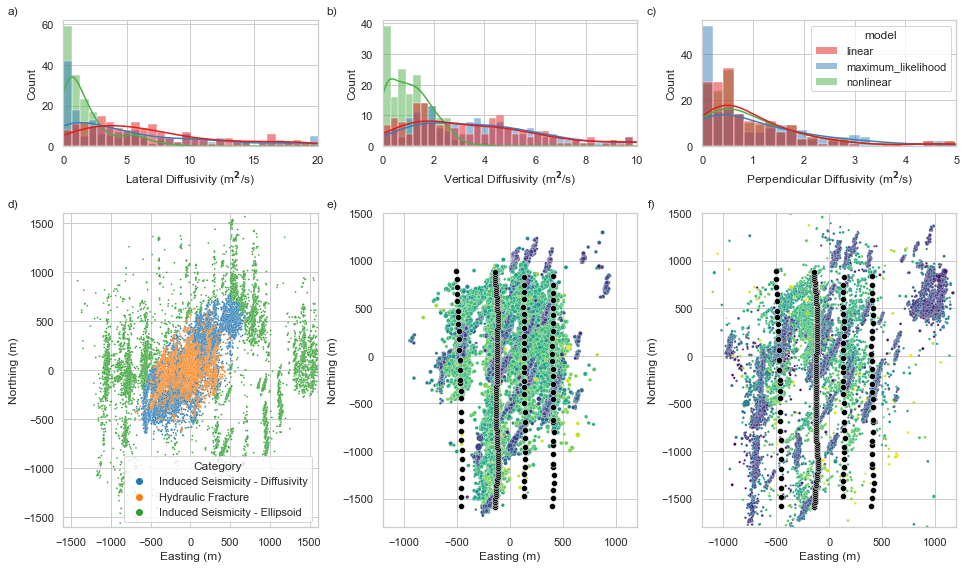

In [9]:
make_diffusivity_comparison_plot(combined_diff_results, nonlinear_bayes_ms_data, stage_data=stagedata)
fig.savefig('figures/5_diffusivity_comparison.pdf', dpi=200)
fig.savefig('figures/5_diffusivity_comparison.png', dpi=200)
plt.show()